In [1]:
# imports and defaults
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import prettyplot as pp
import cn_derivations as cn
import numpy as np
import os
import data_parser as dp
import math
import mpmath
from timeit import default_timer as timer
import r_function_port as rfp

mpmath.dps = 30
mpmath.pretty = True

pd.options.display.max_rows = 10
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
os.getcwd()

# Time zone adjustment
import matplotlib
matplotlib.rcParams['timezone'] = 'CET'

In [2]:
"""Data overview"""
filename = "2019-05-24"
station = "schiessstand"

sdf = dp.scintillometer_parse(filename)

In [3]:
computed_data = cn.data_processor(filename, station)
cdf = computed_data["computed"]
z_eff = computed_data["effective_height"]

Please enter the stability conditions (stable, unstable, or other):
u
Mean path height: 31.83766108843537m
Effective path height: 25.62897860987237m


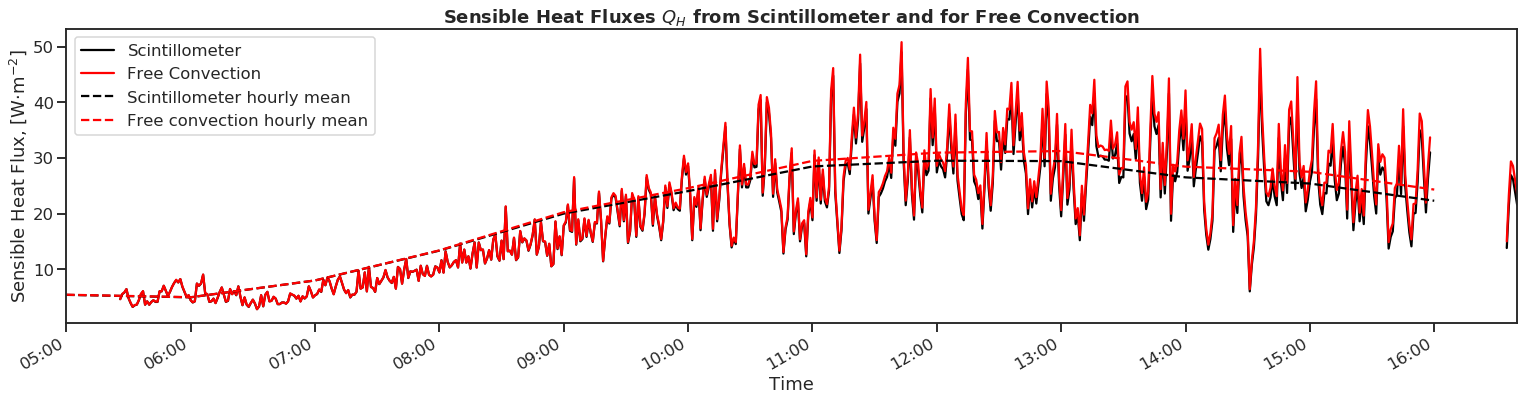

In [4]:
fig = pp.plot_free_convection(sdf, cdf)
plt.show()

In [5]:
"""Ward's iteration"""
# Takes 100s or so to run
cdf_backup = cdf  # in case of later testing
cdf = rfp.ward_method(cdf, z_eff)


Iteration started


/home/nick/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


107.77644658088684s

Iteration completed!


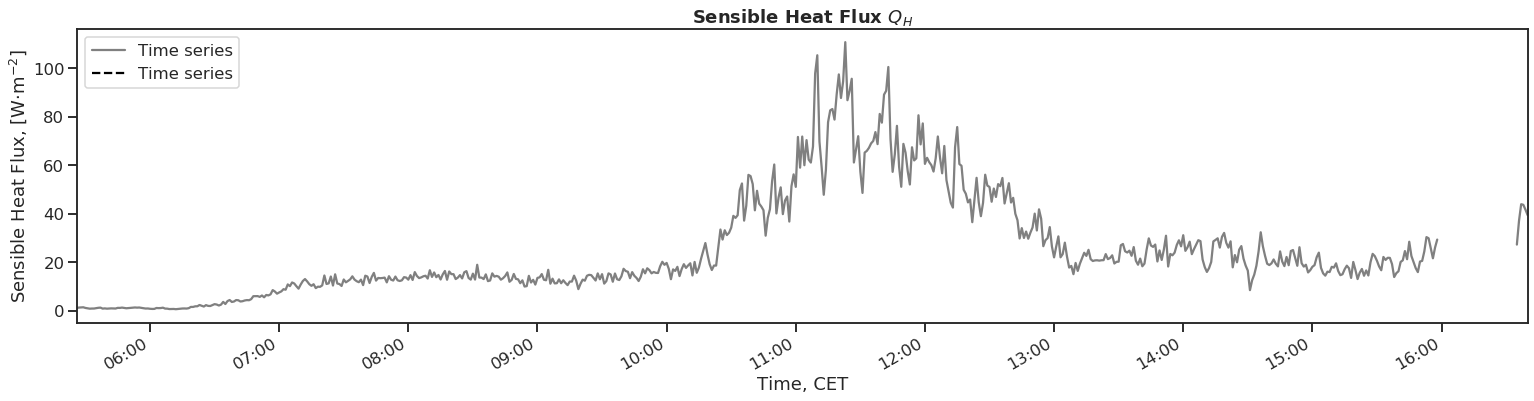

In [6]:
import importlib
importlib.reload(pp)
fig = pp.plot_generic(cdf, "shf")
plt.show()

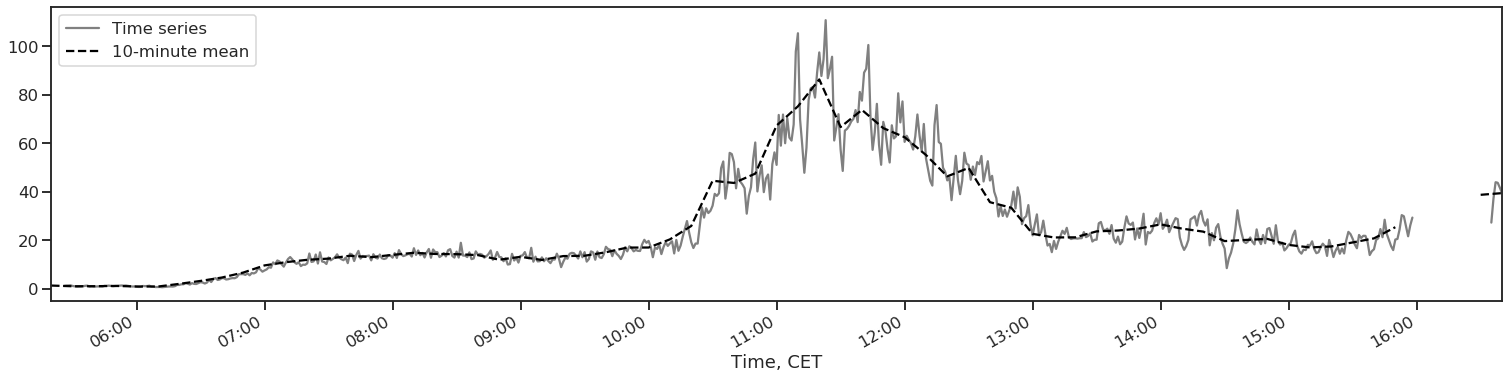

In [84]:
hourly_cdf = pd.DataFrame()
hourly_cdf["shf_mean"] = 0
# hourly_cdf["shf_std"] = hourly_cdf["shf"].astype("float64").resample("H").std()
hourly_cdf["shf_mean"] = cdf["shf"].astype("float64").resample("600S").mean()

fig = plt.figure(figsize=(26, 6))
cdf["shf"].astype("float64").plot(color="grey", label="Time series")
hourly_cdf["shf_mean"].astype("float64").plot(
    color="black", linestyle="dashed", label="10-minute mean")

plt.legend(loc="upper left")
plt.xlabel("Time, CET")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

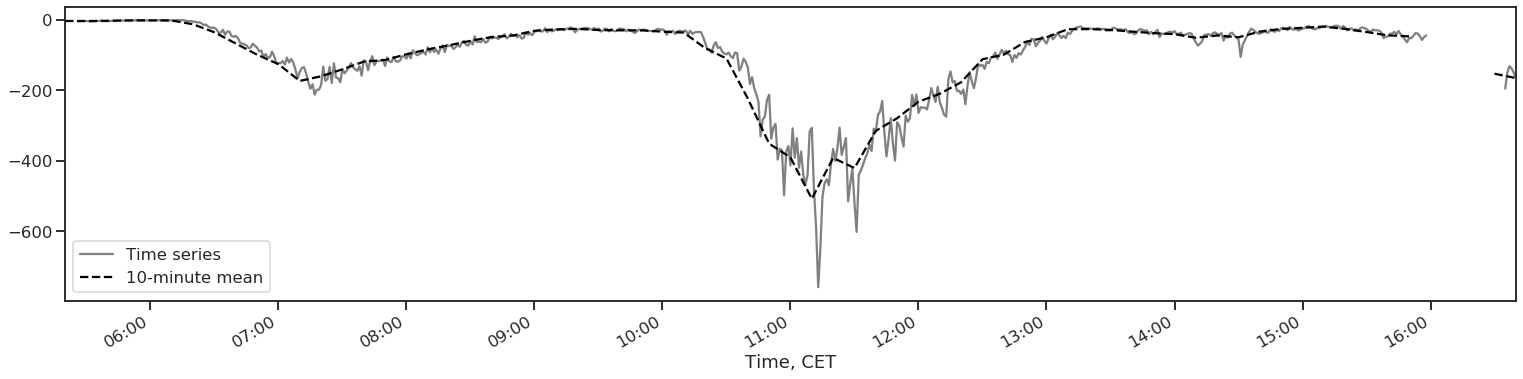

In [86]:
hourly_cdf["obukhov_mean"] = 0
# hourly_cdf["shf_std"] = hourly_cdf["shf"].astype("float64").resample("H").std()
hourly_cdf["obukhov_mean"] = cdf["obukhov"].astype("float64").resample("600S").mean()

fig = plt.figure(figsize=(26, 6))
cdf["obukhov"].astype("float64").plot(color="grey", label="Time series")
hourly_cdf["obukhov_mean"].astype("float64").plot(
    color="black", linestyle="dashed", label="10-minute mean")

plt.legend(loc="lower left")
plt.xlabel("Time, CET")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

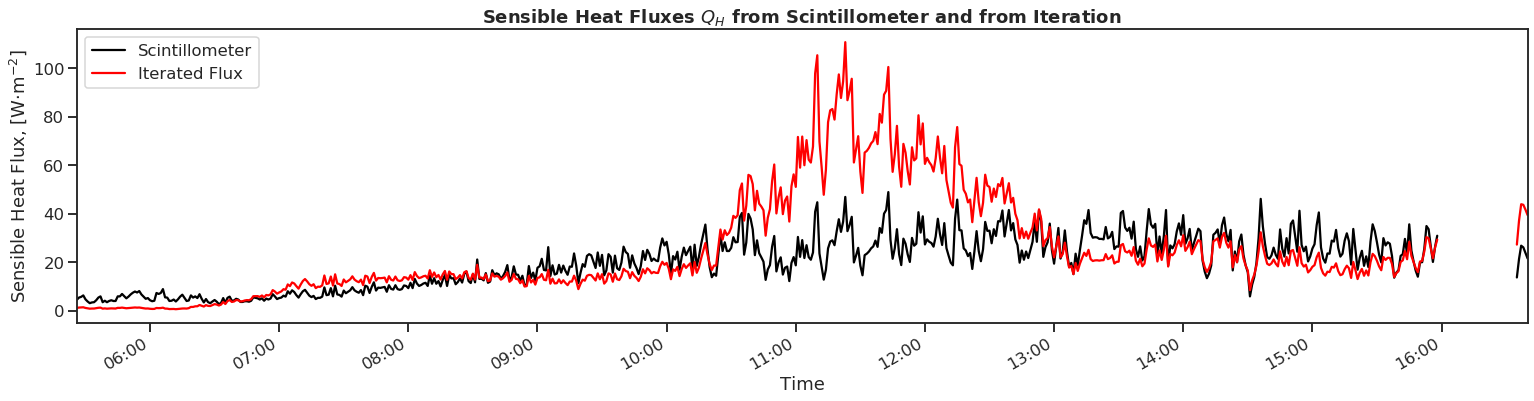

In [8]:
fig = plt.figure(figsize=(26, 6))
sdf["H_convection"].plot(color="black", label="Scintillometer")
cdf["shf"].plot(color="red", label="Iterated Flux")

plt.legend(loc="upper left")
plt.title(
    r"Sensible Heat Fluxes $Q_{H}$ from Scintillometer and from Iteration",
    fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes

In [18]:
cdf = cdf_backup.copy()

In [10]:
cdf_backup = cdf.copy()

In [23]:
cdf = cdf.tz_convert("UTC")

In [90]:
column_headers = ["yyyy", "MM", "day", "HH", "MM", "zm", "d", "z0", "u_mean", "L", "sigma_v", "u_star", "wind_dir"]
ndf = cdf.copy().filter("wind_dir")

ndf["yyyy"] = cdf.index.year
ndf["mm"] = cdf.index.month
ndf["day"] = cdf.index.day
ndf["HH"] = cdf.index.hour
ndf["MM"] = cdf.index.minute
ndf["zm"] = 30 + 50.32
ndf["d"] = 0
ndf["z0"] = -999
ndf["u_mean"] = cdf["windspeed"].mean()
ndf["L"] = cdf["obukhov"].fillna(value=-999)
ndf["sigma_v"] = (np.sqrt(((cdf["windspeed"]-ndf["u_mean"])**2)).mean())
ndf["sigma_v"] = ndf["sigma_v"].fillna(value=-999)
ndf["u_star"] = cdf["u_star"].fillna(value=-999)
ndf["wind_dir"] = cdf["wind_dir"].fillna(value=-999)
ndf

,yyyy,mm,day,HH,MM,zm,d,z0,u_mean,L,sigma_v,u_star,wind_dir
Time,,,,,,,,,,,,,
2019-05-24 03:26:00+00:00,2019,5,24,3,26,80.32,0,-999,1.238227,-4.238933,0.569497,0.038636,290.759511
2019-05-24 03:27:00+00:00,2019,5,24,3,27,80.32,0,-999,1.238227,-3.688550,0.569497,0.038336,288.026937
2019-05-24 03:28:00+00:00,2019,5,24,3,28,80.32,0,-999,1.238227,-3.511752,0.569497,0.038037,285.294363
2019-05-24 03:29:00+00:00,2019,5,24,3,29,80.32,0,-999,1.238227,-3.247494,0.569497,0.037737,282.561788
2019-05-24 03:30:00+00:00,2019,5,24,3,30,80.32,0,-999,1.238227,-3.871792,0.569497,0.037438,279.829214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24 14:36:00+00:00,2019,5,24,14,36,80.32,0,-999,1.238227,-149.781274,0.569497,0.395422,152.782162
2019-05-24 14:37:00+00:00,2019,5,24,14,37,80.32,0,-999,1.238227,-131.891011,0.569497,0.400817,152.582106
2019-05-24 14:38:00+00:00,2019,5,24,14,38,80.32,0,-999,1.238227,-138.046110,0.569497,0.406212,152.382051


In [91]:
ndf_backup = ndf.copy()
ndf = ndf.reset_index(drop=True)
ndf

,yyyy,mm,day,HH,MM,zm,d,z0,u_mean,L,sigma_v,u_star,wind_dir
0,2019,5,24,3,26,80.32,0,-999,1.238227,-4.238933,0.569497,0.038636,290.759511
1,2019,5,24,3,27,80.32,0,-999,1.238227,-3.688550,0.569497,0.038336,288.026937
2,2019,5,24,3,28,80.32,0,-999,1.238227,-3.511752,0.569497,0.038037,285.294363
3,2019,5,24,3,29,80.32,0,-999,1.238227,-3.247494,0.569497,0.037737,282.561788
4,2019,5,24,3,30,80.32,0,-999,1.238227,-3.871792,0.569497,0.037438,279.829214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,2019,5,24,14,36,80.32,0,-999,1.238227,-149.781274,0.569497,0.395422,152.782162
670,2019,5,24,14,37,80.32,0,-999,1.238227,-131.891011,0.569497,0.400817,152.582106
671,2019,5,24,14,38,80.32,0,-999,1.238227,-138.046110,0.569497,0.406212,152.382051
672,2019,5,24,14,39,80.32,0,-999,1.238227,-150.582640,0.569497,0.411608,152.181995


In [92]:
ndf.to_csv(path_or_buf="../../ffp/ffp_export.csv", index=None)
